In [441]:
from rule_generation import * 

### Carregando a base de dados de interesse

Mude a base de dados de acordo com o nome sorteado.

In [442]:
df_name = 's_temp_ubatuba.csv'
df = pd.read_csv(df_name)
df = df.drop(axis=1, labels=['time'])
# df['Volume'] = df['Volume'].apply(lambda x: x/df['Volume'].max())
# df_Close = df['Close'].to_frame()
# df_High = df['High'].to_frame()
# df_Low = df['Low'].to_frame()
# df_Open = df['Open'].to_frame()
# df_Volume = df['Volume'].to_frame()
# df_Close

In [443]:
lagged_columns = [
    (df, 'value')
    # (df_Close, 'Close'),
    # (df_High, 'High'),
    # (df_Low, 'Low'),
    # (df_Open, 'Open'),
    # (df_Volume, 'Volume')
]

Transformando a série temporal em uma base de dados com lags.

In [444]:
def create_lagged_features(lagged_columns, num_lags=3):
    lagged_df = pd.concat([df for df, _ in lagged_columns], axis=1)
    # Create lagged features
    for df, col_name in lagged_columns:
        for lag in range(1, (num_lags + 1)):
            lagged_df[f"{col_name}_lag_{lag}"] = df[col_name].shift(lag)

    # Remove rows with NaN values created by shifting
    lagged_df.dropna(inplace=True)
    lagged_df = lagged_df.drop([col_name for _, col_name in lagged_columns[1:]], axis=1)
    return lagged_df

In [445]:
df_lagged = create_lagged_features(lagged_columns, num_lags=3)

### Criando a variável linguística para cada um dos lags do problema. 

Nessa etapa, crie e modifique as variáveis linguísticas (e seus respectivos conjuntos Fuzzy) para chegar a uma melhor resposta. 

Abaixo tem uma ideia de como criar essa lista de variáveis linguísticas de uma forma enxuta e rápida. Contudo, tente você também fazer suas adaptações.

In [446]:
def create_variable_list(df, target_column):
    variable_list = []
    for col in df.columns:
        min_value = df[col].min()
        max_value = df[col].max()
        try:
            if col != target_column:
                variable_list.append(ctrl.Antecedent(np.arange(min_value - 5, max_value + 5, 0.1), col))
            else:
                variable_list.append(ctrl.Consequent(np.arange(min_value - 5, max_value + 5, 0.1), 'target', defuzzify_method="centroid"))
        except Exception as e:
            print(f"Error processing column {col} [{min_value}, {max_value}]: {e}")
            raise e
    variable_list.reverse()
    return variable_list

In [447]:
def configure_p_functions(var_list, num_fuzzy_sets=3, options = {}):
    for var in var_list:
        var.automf(num_fuzzy_sets)
        try:
            for option in options[var.label]:
                var[option["set"]] = option["func"](var.universe, option["range"])
        except Exception as e:
            print(f"Variable {var.label} not configured, configuring default settings")

In [448]:
def gaussian_conver(uni, args):
    return fuzz.gaussmf(uni, args[0], args[1])

In [449]:
var_list = create_variable_list(df=df_lagged, target_column='value')
var_list

[Antecedent: value_lag_3,
 Antecedent: value_lag_2,
 Antecedent: value_lag_1,
 Consequent: target]

In [450]:
uni = var_list[-1].universe  # TARGET variable
options = {
    # TARGET é mais sensível, então deixo ligeiramente mais achatado pra não ficar doido
    'target': [
        {
            'set': 'poor',
            # 'func': gaussian_conver,
            # 'range': [uni.min(), 1.5]
            'func': fuzz.trimf,
            'range': [uni.min(), uni.min(), np.quantile(uni, 0.25)]
        },
        {
            'set': 'mediocre',
            # 'func': gaussian_conver,
            # 'range': [np.quantile(uni, 0.25), 1.5]
            'func': fuzz.trimf,
            'range': [np.quantile(uni, 0.1), np.quantile(uni, 0.25), np.quantile(uni, 0.45)]
        },
        {
            'set': 'average',
            # 'func': gaussian_conver,
            # 'range': [uni.mean(), 1.5]
            'func': fuzz.trimf,
            'range': [np.quantile(uni, 0.375), uni.mean(), np.quantile(uni, 0.625)]
        },
        {
            'set': 'decent',
            # 'func': gaussian_conver,
            # 'range': [np.quantile(uni, 0.75), 1.5]
            'func': fuzz.trimf,
            'range': [np.quantile(uni, 0.55), np.quantile(uni, 0.75), np.quantile(uni, 0.9)]
        },
        {
            'set': 'good',
            # 'func': gaussian_conver,
            # 'range': [uni.max(), 1.5]
            'func': fuzz.trimf,
            'range': [np.quantile(uni, 0.75), uni.max(), uni.max()]
        }
    ],
}

lag_vars = [
    'value_lag_1', 'value_lag_2', 'value_lag_3'
    #'Close_lag_1',# 'Close_lag_2', 'Close_lag_3',
    #'High_lag_1', #'High_lag_2', 'High_lag_3',
    #'Low_lag_1', #'Low_lag_2', 'Low_lag_3',
    #'Open_lag_1', #'Open_lag_2', 'Open_lag_3',
    #'Volume_lag_1', #'Volume_lag_2', 'Volume_lag_3'
]

variable_index = {var.label: idx for idx, var in enumerate(var_list)}

for name in lag_vars:
    idx = variable_index[name]  # você já deve ter esse dict, ou cria
    uni = var_list[idx].universe

    options[name] = [
        {
            'set': 'poor',
            'func': fuzz.trimf,
            'range': [uni.min(), uni.min(), np.quantile(uni, 0.25)]
        },
        {
            'set': 'mediocre',
            'func': fuzz.trimf,
            'range': [np.quantile(uni, 0.1), np.quantile(uni, 0.4), np.quantile(uni, 0.475)]
        },
        {
            'set': 'average',
            'func': fuzz.trimf,
            'range': [np.quantile(uni, 0.375), uni.mean(), np.quantile(uni, 0.625)]
        },
        {
            'set': 'decent',
            'func': fuzz.trimf,
            'range': [np.quantile(uni, 0.525), np.quantile(uni, 0.6), np.quantile(uni, 0.9)]
        },
        {
            'set': 'good',
            'func': fuzz.trimf,
            'range': [np.quantile(uni, 0.75), uni.max(), uni.max()]
        }
    ]
options = {}

Variable value_lag_3 not configured, configuring default settings
Variable value_lag_2 not configured, configuring default settings
Variable value_lag_1 not configured, configuring default settings
Variable target not configured, configuring default settings


d:\puc\Fuzzy 2025-2\venv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


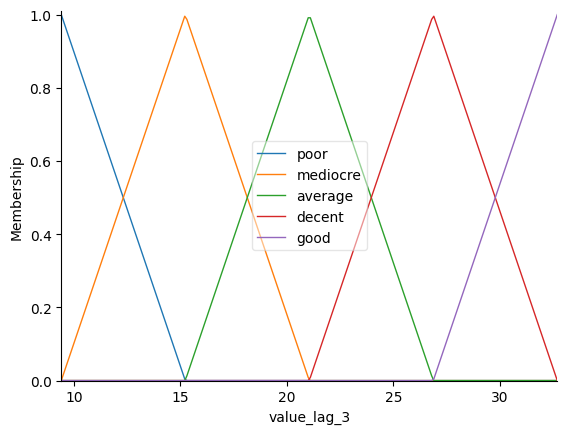

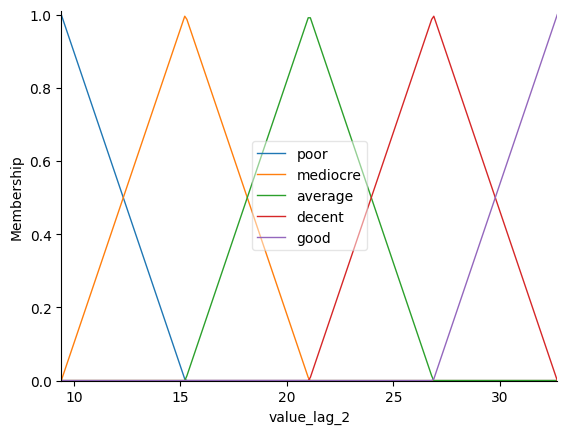

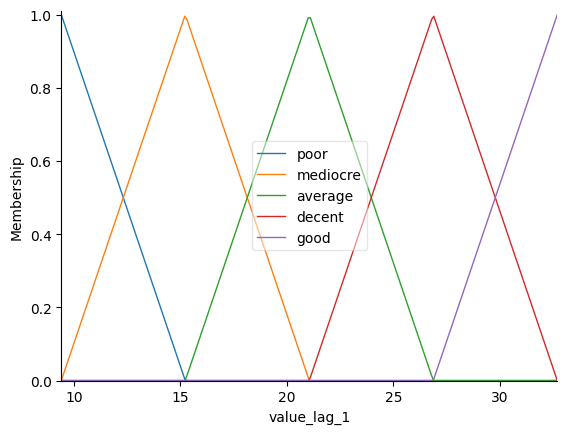

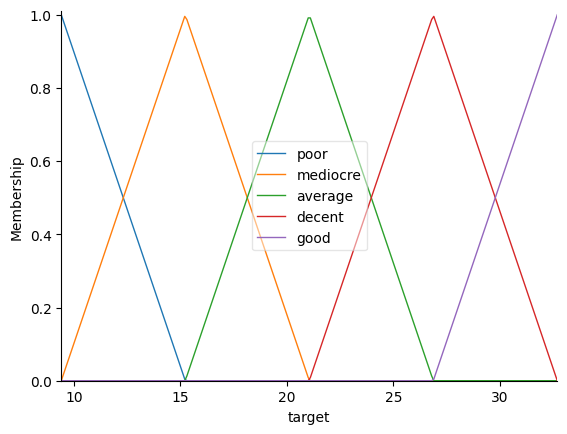

In [451]:
configure_p_functions(var_list, num_fuzzy_sets=5, options=options)
for var in var_list:
    var.view()

### Divisão da base de dados (treino e teste)

In [452]:
# Split between train and test dataframes
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_lagged, test_size=0.1, shuffle=False)
train_df

,value,value_lag_1,value_lag_2,value_lag_3
3,23.7,25.8,25.3,27.1
4,21.6,23.7,25.8,25.3
5,20.0,21.6,23.7,25.8
6,19.3,20.0,21.6,23.7
7,20.2,19.3,20.0,21.6
...,...,...,...,...
103,19.0,19.0,20.1,19.4
104,18.3,19.0,19.0,20.1
105,22.0,18.3,19.0,19.0
106,22.5,22.0,18.3,19.0


### Criando o sistema Fuzzy usando o método Wang-Mendel

In [453]:
# Create fuzzy system with reduced variables (avoids interdependent/cyclic rules)
fuzzy_system = create_fuzzy_system(train_df, var_list, np.fmin)
#pretty_print_rules(fuzzy_system)

### Fazendo a previsão para o conjunto de treino e de teste.

In [454]:
def predict(fuzzy_sim : ctrl.ControlSystemSimulation, df, target_column):
    df_copy = df.copy()
    df_copy.loc[:, 'predict'] = np.nan
    # Create a loop to predict the values 
    for i in range(len(df_copy)):
        # Get all column names except the last one (which will be 'predict')
        input_cols = [col for col in df_copy.columns if col != 'predict' and col != target_column]
        
        # Set each input to the fuzzy system with the actual column name
        for col in input_cols:
            fuzzy_sim.input[col] = df_copy.iloc[i][col]
        try:
            fuzzy_sim.compute()
            out = fuzzy_sim.output['target']
        except Exception as e:
            out = df_copy.iloc[i, 0]  # fallback to first column value
        df_copy.iloc[i, -1] = out 
    return df_copy

In [455]:
fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_system)

predict_train_df = predict(fuzzy_sim=fuzzy_sim, df=train_df, target_column='value')
predict_train_df

,value,value_lag_1,value_lag_2,value_lag_3,predict
3,23.7,25.8,25.3,27.1,25.079334
4,21.6,23.7,25.8,25.3,23.751981
5,20.0,21.6,23.7,25.8,21.950295
6,19.3,20.0,21.6,23.7,19.529126
7,20.2,19.3,20.0,21.6,19.098236
...,...,...,...,...,...
103,19.0,19.0,20.1,19.4,20.737076
104,18.3,19.0,19.0,20.1,20.067620
105,22.0,18.3,19.0,19.0,20.574379
106,22.5,22.0,18.3,19.0,23.453863


In [456]:
predict_test_df = predict(fuzzy_sim=fuzzy_sim, df=test_df, target_column='value')
predict_test_df

,value,value_lag_1,value_lag_2,value_lag_3,predict
108,23.8,23.1,22.5,22.0,23.260037
109,26.2,23.8,23.1,22.5,23.832236
110,25.1,26.2,23.8,23.1,24.092385
111,24.5,25.1,26.2,23.8,23.832236
112,21.6,24.5,25.1,26.2,24.395224
113,19.8,21.6,24.5,25.1,21.910794
114,19.8,19.8,21.6,24.5,19.389533
115,20.1,19.8,19.8,21.6,19.560312
116,20.2,20.1,19.8,19.8,21.345369
117,22.2,20.2,20.1,19.8,21.451581


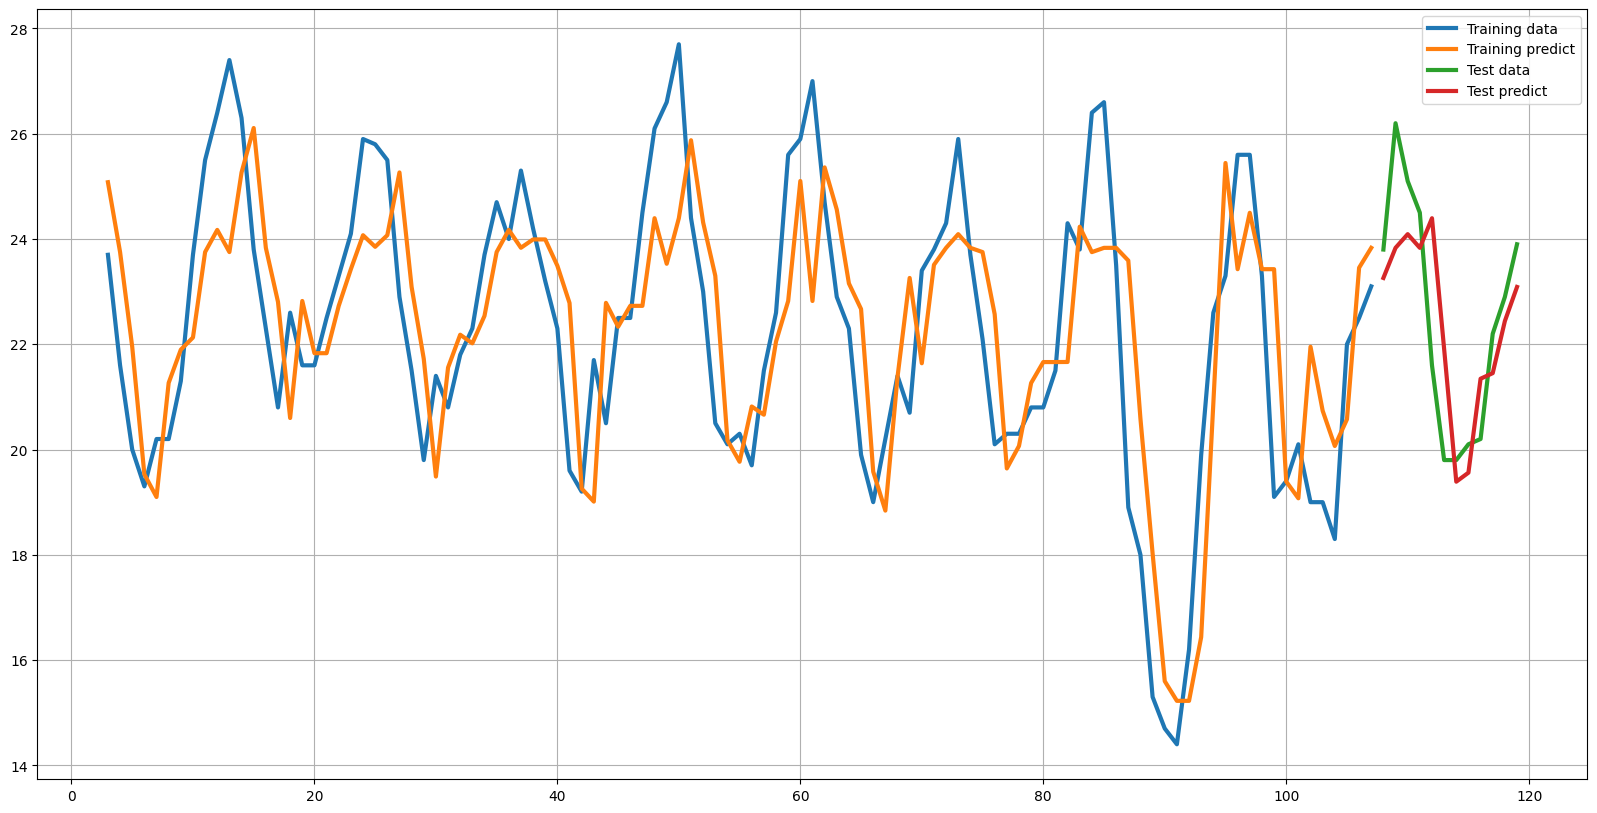

In [457]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20, 10))
plt.plot(predict_train_df['value'], label='Training data', linewidth=3)
plt.plot(predict_train_df['predict'], label='Training predict', linewidth=3)
plt.plot(predict_test_df['value'], label='Test data', linewidth=3)
plt.plot(predict_test_df['predict'], label='Test predict', linewidth=3)
plt.legend()
plt.grid()

plt.show()

In [458]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = predict_test_df['value'].values
y_pred = predict_test_df['predict'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

MAE: 1.1336, RMSE: 1.3792, R²: 0.5834


### Grid Search

In [463]:
def Grid_Search(params: dict, lagged_columns, target_column, initial_train_size=None, step_size=1, verbose=False):
    """Time-series aware grid search using walk-forward validation.

    params: dict with keys 'num_fuzzy_sets' and 'num_lags'
    lagged_columns: same structure used by create_lagged_features
    initial_train_size: number of rows to use for the initial training window (defaults to 50% of data)
    step_size: size of each validation fold (in rows).

    Returns: best_params (dict), best_r2 (float) computed on validation folds.
    """
    from sklearn.metrics import r2_score
    import numpy as np

    best_params = None
    best_r2 = -np.inf

    for num_fuzzy_sets in params['num_fuzzy_sets']:
        for num_lags in params['num_lags']:
            # Recreate lagged features based on num_lags
            df_lagged = create_lagged_features(lagged_columns, num_lags=num_lags)
            variable_list = create_variable_list(df=df_lagged, target_column=target_column)
            configure_p_functions(var_list=variable_list, num_fuzzy_sets=num_fuzzy_sets)

            # Determine initial training window if not provided
            if initial_train_size is None:
                initial_train_size = max(int(len(df_lagged) * 0.5), 10)

            # Walk-forward validation
            start = initial_train_size
            r2_scores = []
            while start + step_size <= len(df_lagged):
                train = df_lagged.iloc[:start]
                val = df_lagged.iloc[start:start + step_size]
                try:
                    fuzzy_system = create_fuzzy_system(train, variable_list, 1)
                    fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_system)
                    predict_val = predict(fuzzy_sim=fuzzy_sim, df=val)
                    y_true = predict_val[target_column].values
                    y_pred = predict_val['predict'].values
                    r2_scores.append(r2_score(y_true, y_pred))
                except Exception:
                    # If a configuration fails, append a very low score to penalize it
                    r2_scores.append(-np.inf)
                start += step_size

            avg_r2 = np.mean(r2_scores) if len(r2_scores) > 0 else -np.inf
            if verbose:
                print(f"num_fuzzy_sets: {num_fuzzy_sets}, num_lags: {num_lags}, avg_r2: {avg_r2:.4f}")

            if avg_r2 > best_r2:
                best_r2 = avg_r2
                best_params = {'num_fuzzy_sets': num_fuzzy_sets, 'num_lags': num_lags}

    return best_params, best_r2

In [ ]:
params = {
    'num_fuzzy_sets': [3, 5],
    'num_lags': [2, 3, 4]
}
#best_params, best_r2 = Grid_Search(params=params, lagged_columns=lagged_columns, target_column='value', initial_train_size=10, step_size=10, verbose=True)
#best_params, best_r2

Variable value_lag_2 not configured, configuring default settings
Variable value_lag_1 not configured, configuring default settings
Variable target not configured, configuring default settings
num_fuzzy_sets: 3, num_lags: 2, avg_r2: -inf
Variable value_lag_3 not configured, configuring default settings
Variable value_lag_2 not configured, configuring default settings
Variable value_lag_1 not configured, configuring default settings
Variable target not configured, configuring default settings
num_fuzzy_sets: 3, num_lags: 3, avg_r2: -inf
Variable value_lag_4 not configured, configuring default settings
Variable value_lag_3 not configured, configuring default settings
Variable value_lag_2 not configured, configuring default settings
Variable value_lag_1 not configured, configuring default settings
Variable target not configured, configuring default settings
num_fuzzy_sets: 3, num_lags: 4, avg_r2: -inf
Variable value_lag_2 not configured, configuring default settings
Variable value_lag_1 n

(None, -inf)

### Item 2

Tomando por base a melhor configuração obtida em (1), realize um passo a passo manual do
procedimento de extração de regras para os dez primeiros registros (i.e., os primeiros pares de
entrada/saída) do trecho da série especificado para você. 

d:\puc\Fuzzy 2025-2\venv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


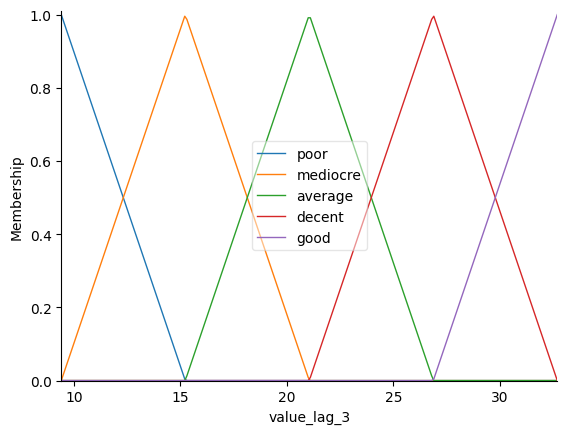

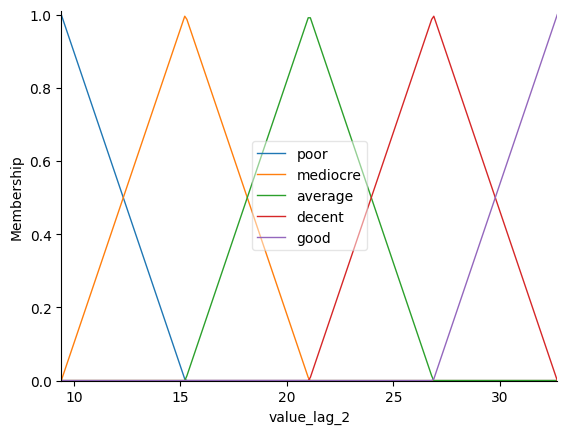

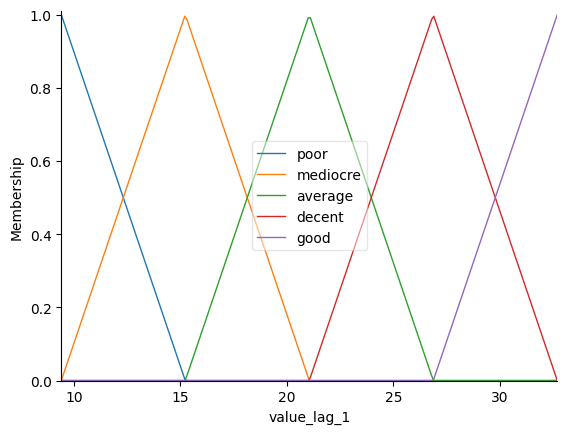

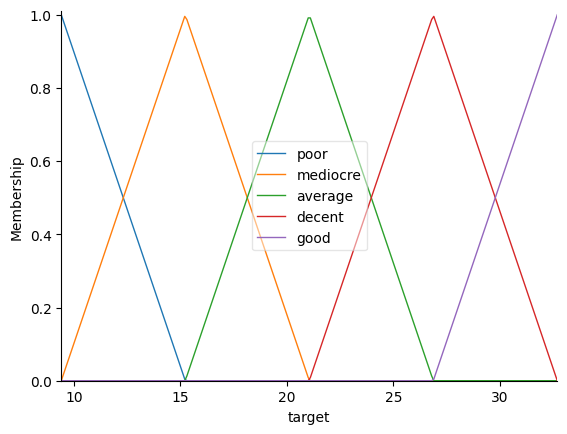

In [467]:
for var in var_list:
    var.view()

In [470]:
predict_train_df.head(10).drop(axis=1, labels=['value'])

,value_lag_1,value_lag_2,value_lag_3,predict
3,25.8,25.3,27.1,25.079334
4,23.7,25.8,25.3,23.751981
5,21.6,23.7,25.8,21.950295
6,20.0,21.6,23.7,19.529126
7,19.3,20.0,21.6,19.098236
8,20.2,19.3,20.0,21.266328
9,20.2,20.2,19.3,21.897338
10,21.3,20.2,20.2,22.128489
11,23.7,21.3,20.2,23.751981
12,25.5,23.7,21.3,24.172644


(1) \
    p_lag1(25.8) = 0.7 [decent]\
    p_lag2(25.3) = 0.6 [decent]\
    p_lag3(27.1) = 0.9 [decent]\
    p_predict(~25.1) = 0.7 [decent]

    candidato:
    IF lag_1 [decent] AND lag_2 [decent] AND lag_3 [good] THEN predict [decent]
(2) \
    p_lag1(23.7) = 0.74 [decent]\
    p_lag2(25.8) = 0.84 [decent]\
    p_lag3(25.3) = 0.94 [decent]\
    p_predict(~23.75) = 0.75 [decent]

    candidato:
    IF lag_1 [decent] AND lag_2 [decent] AND lag_3 [decent] THEN predict [decent]

(3) \
    p_lag1(21.6) = 0.72 [average]\
    p_lag2(23.7) = 0.74 [decent]\
    p_lag3(25.8) = 0.84 [decent]\
    p_predict(~21.95) = 0.805 [average]

    candidato:
    IF lag_1 [average] AND lag_2 [decent] AND lag_3 [decent] THEN predict [average]

(4) \
    p_lag1(20.0) = 1.0 [average]\
    p_lag2(21.6) = 0.72 [average]\
    p_lag3(23.7) = 0.74 [decent]\
    p_predict(~19.5) = 0.53 [mediocre]

    candidato:
    IF lag_1 [average] AND lag_2 [average] AND lag_3 [decent] THEN predict [mediocre]

(5) \
    p_lag1(19.3) = 0.86 [average]\
    p_lag2(20.0) = 1.0 [average]\
    p_lag3(21.6) = 0.72 [average]\
    p_predict(~19.1) = 0.61 [mediocre]

    candidato:
    IF lag_1 [average] AND lag_2 [average] AND lag_3 [average] THEN predict [mediocre]

(6) \
    p_lag1(20.2) = 0.96 [average]\
    p_lag2(19.3) = 0.86 [average]\
    p_lag3(20.0) = 1.0 [average]\
    p_predict(~21.3) = 0.87 [average]

    candidato:
    IF lag_1 [average] AND lag_2 [average] AND lag_3 [average] THEN predict [average]

(7) \
    p_lag1(20.2) = 0.96 [average]\
    p_lag2(20.2) = 0.96 [average]\
    p_lag3(19.3) = 0.86 [average]\
    p_predict(~21.9) = 0.62 [average]

    candidato:
    IF lag_1 [average] AND lag_2 [average] AND lag_3 [average] THEN predict [average]

(8) \
    p_lag1(21.3) = 0.86 [average]\
    p_lag2(20.2) = 0.96 [average]\
    p_lag3(20.2) = 0.96 [average]\
    p_predict(~22.1) = 0.54 [decent]

    candidato:
    IF lag_1 [average] AND lag_2 [average] AND lag_3 [average] THEN predict [decent]

(9) \
    p_lag1(23.7) = 0.74 [decent]\
    p_lag2(21.3) = 0.86 [average]\
    p_lag3(20.2) = 0.96 [average]\
    p_predict(~23.75) = 0.75 [decent]

    candidato:
    IF lag_1 [decent] AND lag_2 [average] AND lag_3 [average] THEN predict [decent]

(10) \
    p_lag1(25.5) = 0.90 [decent]\
    p_lag2(23.7) = 0.74 [decent]\
    p_lag3(21.3) = 0.86 [average]\
    p_predict(~24.2) = 0.83 [decent]

    candidato:
    IF lag_1 [decent] AND lag_2 [decent] AND lag_3 [average] THEN predict [decent]


#### Regras e Conflitos

1. OK\
**IF lag_1 [decent] AND lag_2 [decent] AND lag_3 [good] THEN predict [decent]**

2. OK\
**IF lag_1 [decent] AND lag_2 [decent] AND lag_3 [decent] THEN predict [decent]**

3. OK\
**IF lag_1 [average] AND lag_2 [decent] AND lag_3 [decent] THEN predict [average]**

4. OK\
**IF lag_1 [average] AND lag_2 [average] AND lag_3 [decent] THEN predict [mediocre]**

5. Conflito com 6,7,8; 0.86 * 1.0 * 0.72 * 0.61 = 0.3777\
IF lag_1 [average] AND lag_2 [average] AND lag_3 [average] THEN predict [mediocre]

6. Conflito com 5,7,8; **0.96 * 0.86 * 1.0 * 0.87 = 0.7183**\
**IF lag_1 [average] AND lag_2 [average] AND lag_3 [average] THEN predict [average]**

7. Conflito com 5,6,8; 0.96 * 0.96 * 0.86 * 0.62 = 0.4914\
IF lag_1 [average] AND lag_2 [average] AND lag_3 [average] THEN predict [average]

8. Conflito com 5,6,7; 0.86 * 0.96 * 0.96 * 0.54 = 0.4280\
IF lag_1 [average] AND lag_2 [average] AND lag_3 [average] THEN predict [decent]

9. OK\
**IF lag_1 [decent] AND lag_2 [average] AND lag_3 [average] THEN predict [decent]**

10. OK\
**IF lag_1 [decent] AND lag_2 [decent] AND lag_3 [average] THEN predict [decent]**

## Regras geradas

1. IF lag_1 [decent] AND lag_2 [decent] AND lag_3 [good] THEN predict [decent]
2. IF lag_1 [decent] AND lag_2 [decent] AND lag_3 [decent] THEN predict [decent]
3. IF lag_1 [average] AND lag_2 [decent] AND lag_3 [decent] THEN predict [average]
4. IF lag_1 [average] AND lag_2 [average] AND lag_3 [decent] THEN predict [mediocre]
5. IF lag_1 [average] AND lag_2 [average] AND lag_3 [average] THEN predict [average]
6. IF lag_1 [decent] AND lag_2 [average] AND lag_3 [average] THEN predict [decent]
7. IF lag_1 [decent] AND lag_2 [decent] AND lag_3 [average] THEN predict [decent]